## Quasi-Lagrangian view of a tropical cyclone
**09 November 2021 by MiniUFO**

---
[TOC]

---
### 1. Introduction
[Tropical cyclone](https://simple.wikipedia.org/wiki/Tropical_cyclone) (TC) is a moving disaster on earth's surface that brings in gale wind, heavy rainfall, and storm surge to the people living in coastal regions.  It is well-known that the strong rotational wind about the TC center is asymmetric: on the right-hand side of the forward direction, the wind is much stronger than the one on the left-hand side.  This is a classic Eulerian view from satellite data.  If one take a view on this while moving with the TC, this asymmetry will be greatly reduced.  Also, a TC is generally characterized by a rotational wind at lower levels, and thus it is best described in a cylindrical coordinates translating with the system.  This is called quasi-Lagrangian view.  Here we will use [`xvortices`](https://github.com/miniufo/xvortices) package to give a quick tutorial on how to take such quasi-Lagrangian view of a tropical cyclone.

![cylind plot](https://raw.githubusercontent.com/miniufo/xvortices/master/pics/cylind.jpg)

---
### 2. Methods
#### 2.1 Load lat/lon data
For analysis of a tropical cyclone, it is convenient to use [`besttracks`](https://github.com/miniufo/besttracks) package to load the tropical cyclone information from a Best Track dataset.  Here, we will use the Chinese Meteorological Agency (CMA) data.

<xarray.Dataset>
Dimensions:  (time: 22, lat: 61, lon: 71, lev: 37)
Coordinates:
  * time     (time) datetime64[ns] 2004-09-11 ... 2004-09-16T06:00:00
  * lat      (lat) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 56.0 57.0 58.0 59.0 60.0
  * lon      (lon) float32 80.0 81.0 82.0 83.0 84.0 ... 147.0 148.0 149.0 150.0
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 ... 175.0 150.0 125.0 100.0
Data variables:
    u        (time, lev, lat, lon) float32 ...
    v        (time, lev, lat, lon) float32 ...
    w        (time, lev, lat, lon) float32 ...
    h        (time, lev, lat, lon) float32 ...
Attributes:
    comment:  uwnd
    storage:  99


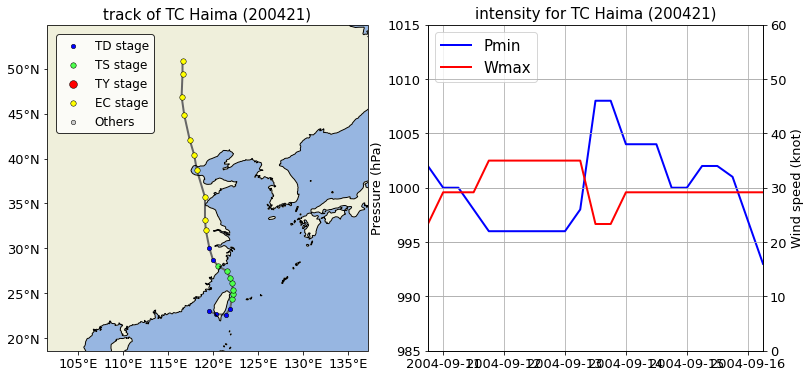

In [1]:
# loading data
import xarray as xr
import sys
sys.path.append('../../')
from besttracks.besttracks import parse_TCs
%matplotlib inline

# read lat/lon data from a NetCDF file
dset = xr.open_dataset('../tests/Haima2004.nc')
print(dset)

# select a TC data: Haima in 2004 over the WNP
haima = parse_TCs('d:/Data/Typhoons/CMA/original/*.txt', agency='CMA',
                  tc_cond=(lambda tc:tc.ID=='200421'))[0]
haima.plot()

#### 2.2 Interpolation onto cylindrical coordinate
Notice that the time range of the lat/lon gridded dataset is the same as the TC Haima.  This is generally not necessary as [`xarray`](http://xarray.pydata.org/) will take a broadcast along the time dimension.  Now we use [`xvortices`](https://github.com/miniufo/xvortices) to interpolate lat/lon data onto cylindrical coordinate.

In [2]:
from xvortices.xvortices import load_cylind

olon = haima.get_as_xarray('LON')[1:] # selecting the same time range as dset
olat = haima.get_as_xarray('LAT')[1:] # selecting the same time range as dset

[u, v, w, h], lons, lats, etas = \
            load_cylind(dset, olon, olat,                 # use haima's lat/lon for the center of cylind coordinate
                        azimNum=72, radiNum=31, radMax=6, # use default cylindrical coordinate setup
                        lonname='lon', latname='lat')     # coordinate names in xr.Dataset

print(h)

<xarray.DataArray 'h' (time: 22, lev: 37, radi: 31, azim: 72)>
array([[[[ 4.19759983e+01,  4.19759983e+01,  4.19759983e+01, ...,
           4.19759983e+01,  4.19759983e+01,  4.19759983e+01],
         [ 4.15719982e+01,  4.15557450e+01,  4.15426608e+01, ...,
           4.16387558e+01,  4.16136288e+01,  4.15913306e+01],
         [ 4.20439976e+01,  4.20040766e+01,  4.19434696e+01, ...,
           4.20414947e+01,  4.20623696e+01,  4.20633402e+01],
         ...,
         [ 9.41640185e+01,  1.02117510e+02,  1.06882455e+02, ...,
           5.84489715e+01,  7.11640726e+01,  8.33183396e+01],
         [ 9.69800187e+01,  1.04937256e+02,  1.09560427e+02, ...,
           5.97124972e+01,  7.30299645e+01,  8.57957787e+01],
         [ 9.97960188e+01,  1.07733667e+02,  1.12192514e+02, ...,
           6.14116280e+01,  7.48696293e+01,  8.82766622e+01]],

        [[ 2.64113998e+02,  2.64113998e+02,  2.64113998e+02, ...,
           2.64113998e+02,  2.64113998e+02,  2.64113998e+02],
         [ 2.63257998e+02

Now we are able to plot the interpolated fields $u$, $v$, $w$, and $h$ in a cylindrical grid.  Notice that the cylindrical coordinate is define on the spherical earth, and it looks more like a circle on a **Lambert conformal projection** (lcc).

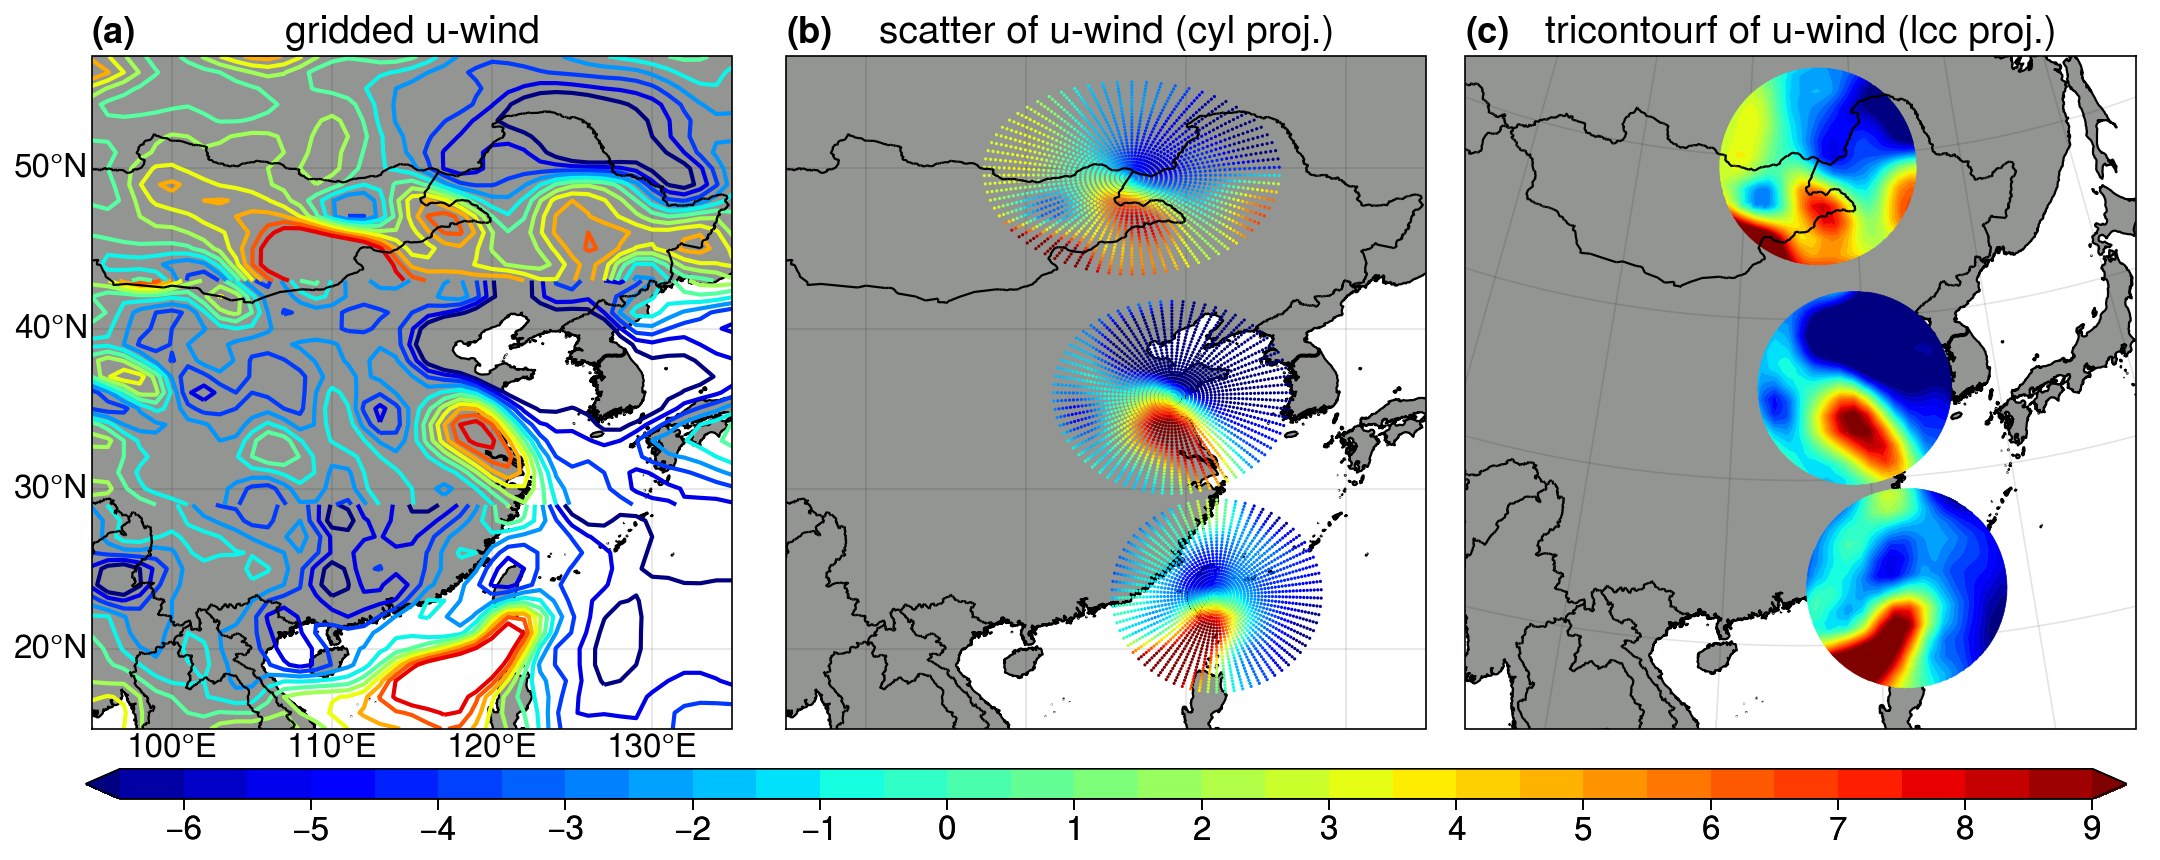

In [3]:
# plot horizontal interpolation
import proplot as pplt
import numpy as np

# select times and level for a horizontal slice
zlev  =  3
tlevs = [2, 14, 20]

pplt.rc.reso = 'hi'
fontsize = 14

fig, axes = pplt.subplots(nrows=1, ncols=3, figsize=(10.8,4.3), sharex=3, sharey=3,
                          proj=[pplt.Proj('cyl', lon_0=180),
                                pplt.Proj('cyl', lon_0=180),
                                pplt.Proj('lcc', lon_0=115, lat_0=38)])

latbands = [slice(15, 29),slice(29, 43), slice(43,57)]

ax = axes[0,0]
for tlev, latband in zip(tlevs, latbands):
    ax.contour(dset.u[tlev, zlev].sel(lat=latband), cmap='jet', vmin=-6.5, vmax=9, extend='both')
ax.set_title('gridded u-wind', fontsize=fontsize)
ax.format(labels=True, lonlabels='b', latlabels='l', latlim=[15, 57], lonlim=[95, 135])

ax = axes[0,1]
for tlev in tlevs:
    ax.scatter(lons[tlev].data.flatten(), lats[tlev].data.flatten(), s=0.3, c=u[tlev, zlev].data.ravel(),
               cmap='jet', zorder=2, vmin=-6.5, vmax=9)
ax.set_title('scatter of u-wind (cyl proj.)', fontsize=fontsize)
ax.format(labels=False, latlim=[15, 57], lonlim=[95, 135])

ax = axes[0,2]
for tlev in tlevs:
    m=ax.tricontourf(lons[tlev].data.flatten(), lats[tlev].data.flatten(), u[tlev,zlev].data.ravel(),
                     levels=np.linspace(-6.5,9,32), cmap='jet', zorder=2, extend='both')
ax.set_title('tricontourf of u-wind (lcc proj.)', fontsize=fontsize)
ax.format(labels=False, latlim=[15, 54.8], lonlim=[95, 135])

fig.colorbar(m, loc='b', length=0.98, cols=(1,3), ticks=1, width=0.15, pad=0.0)

axes.format(abc='(a)', land=True, landcolor='gray', borders=True, coast=True, lonlines=10, latlines=10, coastcolor='k')

#### 2.3 Quasi-Lagrangian view and vector re-projection
Now, we will subtract the translating velocity of the TC system from the velocity components, and obtain the storm-relative velocity.  This is a quasi-Lagrangian view of the wind vector.

In [4]:
from xvortices.xvortices import project_to_cylind

# calculate translating velocity of the TC
haima.translate_velocity()

uo = haima.get_as_xarray('uo')
vo = haima.get_as_xarray('vo')

# storm-relative wind components
u_r = u - uo
v_r = v - vo

# reproject the wind vector into azimuthal and radial components
uaz_r, vra_r = project_to_cylind(u_r, v_r, etas)

It is clear from the meridional wind component (v) that if one moves with the TC towards north, he will feel more wind towards him.  As a result, the storm-relative v is more negative than the original one.

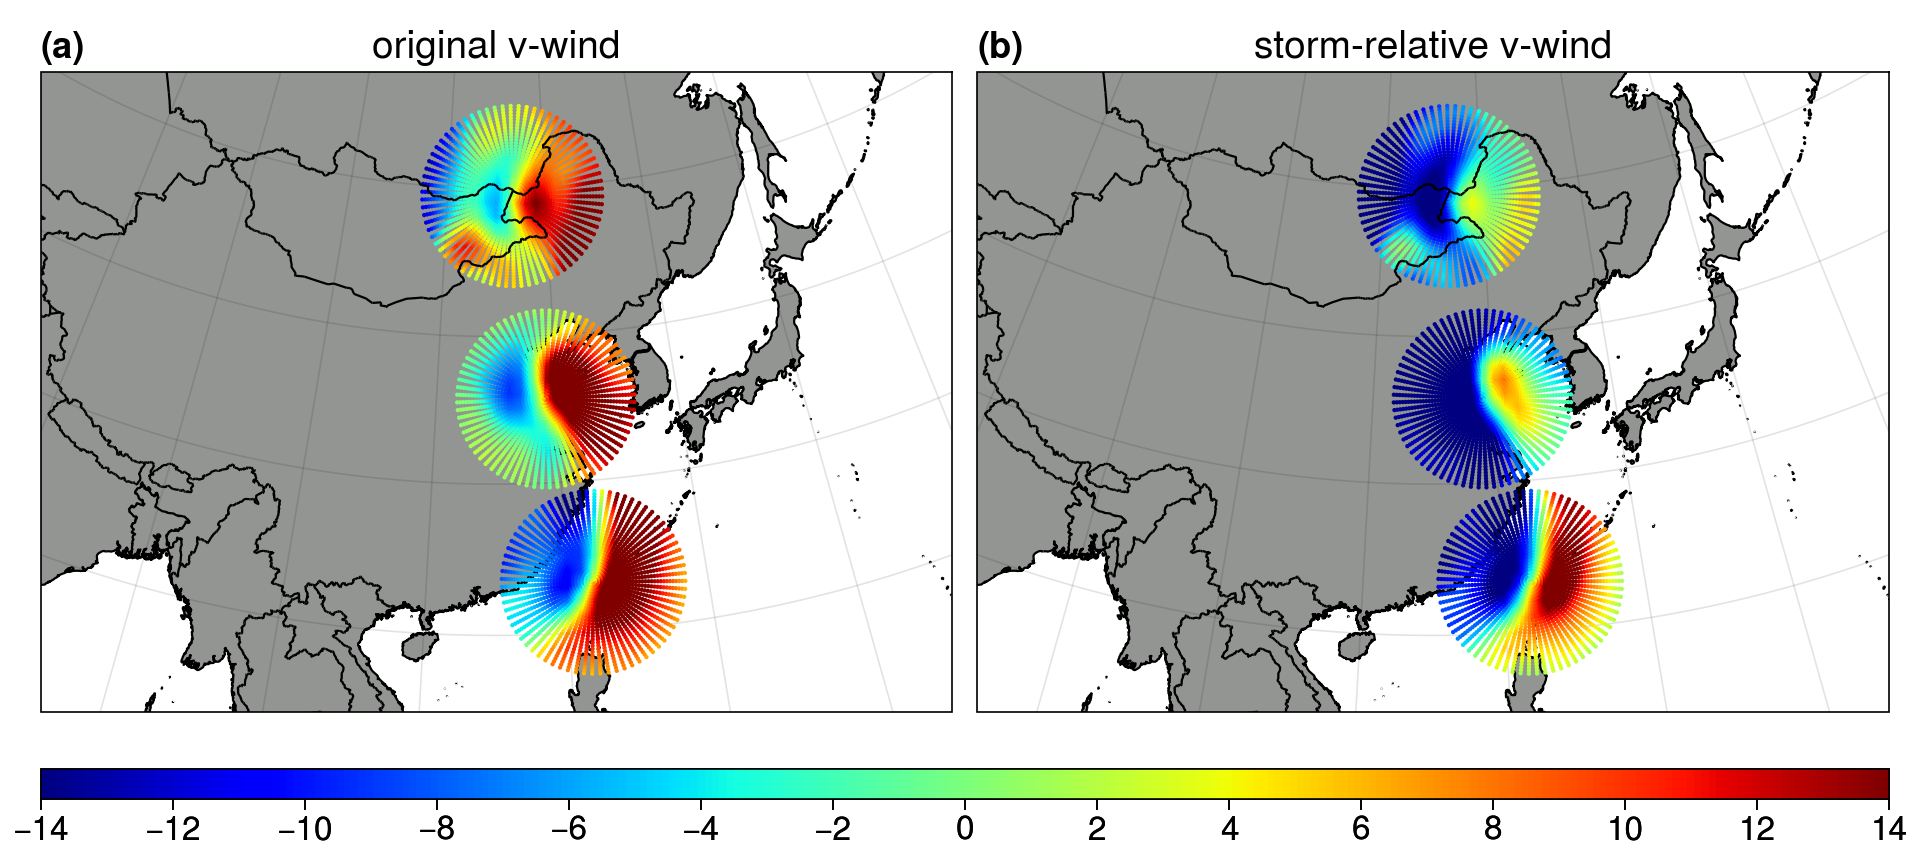

In [5]:
# comparison of original and storm-relative v
import proplot as pplt
import numpy as np

# select times and level for a horizontal slice
zlev  =  5
tlevs = [2, 14, 20]

pplt.rc.reso = 'hi'
fontsize = 14

fig, axes = pplt.subplots(nrows=1, ncols=2, figsize=(9.6,4.3), sharex=0, sharey=0,
                          proj=[pplt.Proj('lcc', lon_0=115, lat_0=38), pplt.Proj('lcc', lon_0=115, lat_0=38)])

ax = axes[0,0]
for tlev in tlevs:
    ax.scatter(lons[tlev].data.flatten(), lats[tlev].data.flatten(), s=0.9, c=v[tlev, zlev].data.ravel(),
               cmap='jet', zorder=2, vmin=-14, vmax=14)
ax.set_title('original v-wind', fontsize=fontsize)
ax.format(labels=False, latlim=[15, 54.8], lonlim=[85, 145])

ax = axes[0,1]
for tlev in tlevs:
    m=ax.scatter(lons[tlev].data.flatten(), lats[tlev].data.flatten(), s=0.9, c=v_r[tlev,zlev].data.ravel(),
                 cmap='jet', zorder=2, vmin=-14, vmax=14)
ax.set_title('storm-relative v-wind', fontsize=fontsize)
ax.format(labels=False, latlim=[15, 54.8], lonlim=[85, 145])

fig.colorbar(m, loc='b', length=1, cols=(1,2), ticks=2, width=0.15, pad=0.0)

axes.format(abc='(a)', land=True, landcolor='gray', borders=True, coast=True, lonlines=10, latlines=10, coastcolor='k')

#### 2.4 Basic structures of a TC
Now it is able to plot the basic structures of this TC, through a simple azimuthal average of the storm-relative wind, vertical velocity, and the geopotential height.  Notice that the original data is on a coarse resolution grid (1-degree), and the TC structure is not compact.

In [6]:
# azimuthal mean
uaz_rm = uaz_r.mean('azim')
vra_rm = vra_r.mean('azim')
wm = w.mean('azim')
hm = h.mean('azim')

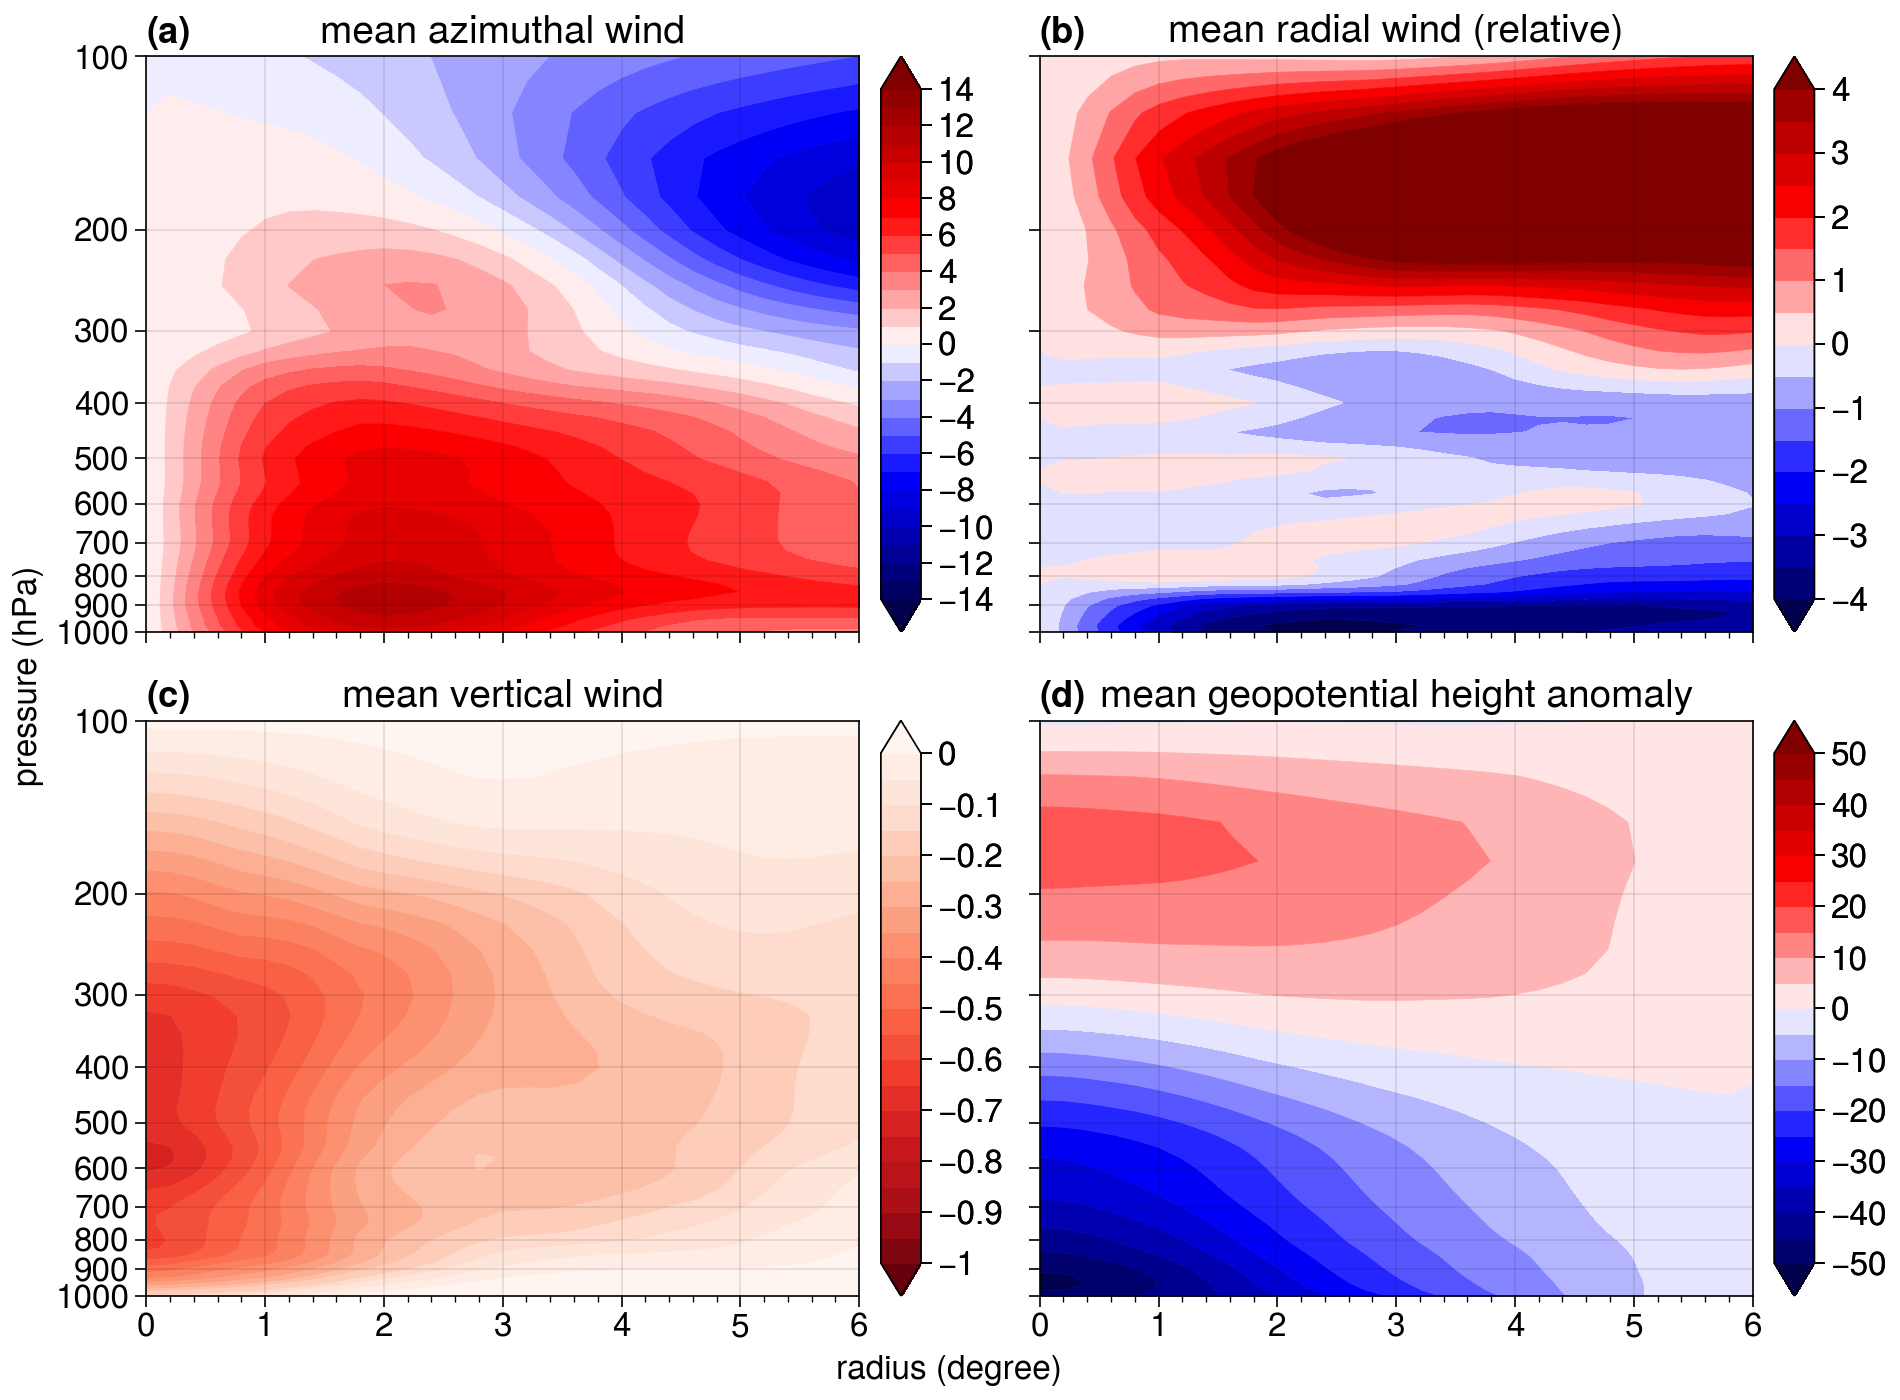

In [7]:
# plot azimuthal-mean structure of TC
import proplot as pplt
import numpy as np

tlev = 2

fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(9.5,7), sharex=3, sharey=3)

fontsize = 14

ax = axes[0,0]
m=ax.contourf(uaz_rm[tlev], levels=np.linspace(-14,14,29), cmap='seismic', extend='both')
ax.set_title('mean azimuthal wind', fontsize=fontsize)
ax.colorbar(m, loc='r', length=1, label='')

ax = axes[0,1]
m=ax.contourf(vra_rm[tlev], levels=np.linspace(-4,4,17), cmap='seismic', extend='both')
ax.set_title('mean radial wind (relative)', fontsize=fontsize)
ax.colorbar(m, loc='r', length=1, label='')

ax = axes[1,0]
m=ax.contourf(wm[tlev], levels=np.linspace(-1,0,21), cmap='reds_r', extend='both')
ax.set_title('mean vertical wind', fontsize=fontsize)
ax.colorbar(m, loc='r', length=1, label='')

ax = axes[1,1]
m=ax.contourf(hm[tlev]-hm[tlev,:,-1], levels=np.linspace(-50,50,21), cmap='seismic', extend='both')
ax.set_title('mean geopotential height anomaly', fontsize=fontsize)
ax.colorbar(m, loc='r', length=1, label='')

axes.format(abc='(a)', xlabel='radius (degree)', ylabel='pressure (hPa)', yscale='log', ylocator=np.linspace(100, 1000, 10))

---
### References
1. Yuan, Z., and M. Jian, 2002: [On the forced tangentially-averaged radial-vertical circulation within vortices. Part I: Concepts and equations](https://link.springer.com/article/10.1007/s00376-002-0058-0). *Adv. Atmos. Sci.*, **19**, 953-964.
2. Qian, Y.-K., C.-X. Liang, Q. Liang, L. Lin, and Z. Yuan, 2011: [On the forced tangentially-averaged radial-vertical circulation within vortices. Part II: The transformation of Tropical Storm Haima (2004)](https://link.springer.com/article/10.1007/s00376-010-0060-x). *Adv. Atmos. Sci.*, **28**, 1143-1158.